# Digital acceptance testing

Goal is to make it easy to modify f-eng configuration while recording data.

1. Write MS file
- set all inputs to zeros
- set pol a inputs to adc, then pol b to adc
- set eq coeffs to zero for first ten channels on first snap, then iterate through all snaps

2. Write beamformed data
- set inputs to zeros
- set pol a inputs to adc, then pol b to adc
- set eq coeffs to zero for first ten channels on first snap, then iterate through all snaps
3. Read autos from MS file
- confirm order of zeros, adc on pol on sequence, channel off sequence, and antennas off sequence
4. Read beamformed data
- confirm order of zeros, adc on pol order, channel off order by channel

### Setup

In [1]:
%matplotlib inline

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from matplotlib import animation
from matplotlib import pyplot as plt
from IPython.display import Image

from mnc import control
from lwa_f import snap2_fengine, snap2_feng_etcd_client
from lwa_antpos import mapping
import casacore.tables
from retry import retry

/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/mnc/control.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-p

Read antpos from etcd


In [4]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, DataRange1d, Select
from bokeh.palettes import Viridis
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()

Loading BokehJS ...

In [27]:
snap2names = [f'snap{i:02}' for i in range(1, 12)]

def set_input(mode='use_zero', stream=None, pol=None, names=snap2names):
    """ Set the input block method
    mode can be "use_zero", "use_adc", "use_noise", "zero_coeffs",
    "reset_coeffs", "get_status".
    """

    if isinstance(names, str):
        names = [names]

    for name in names:
        f = snap2_fengine.Snap2Fengine(name)
        num = int(name.lstrip('snap'))

        if (pol is None) or isinstance(stream, int):
            print(f"Set stream: {stream}")
            run(f, stream, mode=mode)
        elif (stream is None) and (pol is not None):
            antpols = []
            if pol == 'a':
                inps = list(range(0,64,2))
            elif pol == 'b':
                inps = list(range(1,64,2))
            for inp in inps:
                antpols.append(mapping.snap2_to_antpol(num, inp))
                run(f, inp, mode=mode)
            print(f"Set antpols {antpols}")

@retry(RuntimeError, tries=2)
def run(f, stream, mode='use_zero', zerochans=range(0, 5)):
    if mode == 'use_zero':
        f.input.use_zero(stream)
    elif mode == 'use_adc':
        f.input.use_adc(stream)
    elif mode == 'use_noise':
        f.input.use_noise(stream)
    elif mode == 'get_status':
        print('input status:')
        f.input.get_status()
        print('eqtvg status:')
        f.eqtvg.get_status()
    elif mode == 'reset_coeffs':
        f.eq.initialize(read_only=False)
    elif mode == 'zero_coeffs':
        for i in range(64):
            coeffs, scalefactor = f.eq.get_coeffs(i)
            # [1] is scale factor (coeff binary point), coeff = 9600/2**scalefactor?
            coeffs2 = coeffs >> zeropoint
            coeffs2[:5] = 0
            f.eq.set_coeffs(i, coeffs=coeffs2)
    else:
        print(f'mode {mode} not recognized')
# or
#        f.eqtvg.tvg_enable()
#        f.eqtvg.write_stream_tvg()
#        f.eqtvg.write_const_per_stream()
#        f.eqtvg.write_freq_ramp()

def plot_autospecs(names=snap2names, ret=False, bokeh=True):
    """ plots auto correlations for sets of snap2names.
    Can optionally return array with ret=True.
    """

    if isinstance(names, str):
        names = [names]

    autospecs = []
    for name in names:
        f = snap2_fengine.Snap2Fengine(name)
        for i in range(64):
            spec = f.corr.get_new_corr(i, i).real  # 8-channel average, normalized by accumulated time/chans
            autospecs.append(spec)
    autospecs = np.vstack(autospecs)

    if bokeh:
        TOOLTIPS = [("x", "$x"), ("y", "$y"), ("value", "@image")]
        plot = figure(plot_width=800, plot_height=400, tooltips=TOOLTIPS)
        _ = plot.image(image=[autospecs], x=0, y=0, dw=512, dh=len(autospecs), palette=Viridis[4])
        plot.xaxis.axis_label = 'Channel (8-chan avg)'
        plot.yaxis.axis_label = 'Input (64 per snap, stacked)'
        show(plot)
    else:
        fig, (ax0) = plt.subplots(1, 1, figsize=(12,12))
        ax0.imshow(autospecs, origin='lower', interpolation='nearest')

    if ret:
        return autospecs

In [6]:
con = control.Controller("/home/ubuntu/proj/lwa-shell/mnc_python/config/lwa_corr_config.yaml")

In [7]:
con.start_fengine()

2022-05-25 11:18:31,436 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-05-25 11:18:31,726 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:18:32,019 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
snap02 is already connected.
2022-05-25 11:18:32,433 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-05-25 11:18:32,870 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:18:33,263 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 1
snap03 is already connected.
2022-05-25 11:18:33,961 - lwa_f.blocks.block:snap04 - WARNING -  - hostname (10.40.0.134) couldn't be turned into integer serial
2022-05-25 11:18:34,209 - lwa_f.blocks.block:snap04 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:18:34,451 - lwa_f.blocks.block:snap04 - I

In [37]:
con.start_xengine()

DEBUG:Got command response
DEBUG:Response: {'id': '1653506848693627', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506848.7113543}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506848719948', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506848.7305562}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506848743511', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506848.7545676}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506848764478', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506848.7786043}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506848808915', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506848.8154037}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506848831782', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506848.8383737}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506848848953', 'val': {'status': 'normal', 'r

DEBUG:Got command response
DEBUG:Response: {'id': '1653506849653339', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506849.6686516}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506849671335', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506849.6900926}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506849693276', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506849.7100832}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506849712844', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506849.7295399}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506849732368', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506849.7484627}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506849751135', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653506849.7683523}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506849770811', 'val': {'status': 'normal', 'r

2022-05-25 19:27:58 [INFO    ] Pipelines all appear to be ready after 17.9 seconds


INFO:Pipelines all appear to be ready after 17.9 seconds
INFO:pipelines up? True


pipelines up? True
2022-05-25 19:27:58 [INFO    ] Setting max data output rate per pipeline to 625.0 Mbit/s


INFO:Setting max data output rate per pipeline to 625.0 Mbit/s


2022-05-25 19:27:58 [INFO    ] Setting pipeline lxdlwagpu01:0 data destination to 10.41.0.25:10001


INFO:Setting pipeline lxdlwagpu01:0 data destination to 10.41.0.25:10001
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878914913', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.9180315}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878926194', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.9300182}}


2022-05-25 19:27:58 [INFO    ] Setting pipeline lxdlwagpu01:1 data destination to 10.41.0.25:10001


INFO:Setting pipeline lxdlwagpu01:1 data destination to 10.41.0.25:10001
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878934441', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.938211}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878941598', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.9444764}}


2022-05-25 19:27:58 [INFO    ] Setting pipeline lxdlwagpu01:2 data destination to 10.41.0.72:10001


INFO:Setting pipeline lxdlwagpu01:2 data destination to 10.41.0.72:10001
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878948585', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.9526446}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878955200', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.9579213}}


2022-05-25 19:27:58 [INFO    ] Setting pipeline lxdlwagpu01:3 data destination to 10.41.0.72:10001


INFO:Setting pipeline lxdlwagpu01:3 data destination to 10.41.0.72:10001
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878960727', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.964362}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878966776', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.9703631}}


2022-05-25 19:27:58 [INFO    ] Setting pipeline lxdlwagpu02:0 data destination to 10.41.0.25:10002


INFO:Setting pipeline lxdlwagpu02:0 data destination to 10.41.0.25:10002
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878975278', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506878.9799027}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506878983967', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.1564333}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu02:1 data destination to 10.41.0.25:10002


INFO:Setting pipeline lxdlwagpu02:1 data destination to 10.41.0.25:10002
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879161488', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.2561777}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879259921', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.4327312}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu02:2 data destination to 10.41.0.72:10002


INFO:Setting pipeline lxdlwagpu02:2 data destination to 10.41.0.72:10002
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879437016', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.5069923}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879509936', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.5135257}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu02:3 data destination to 10.41.0.72:10002


INFO:Setting pipeline lxdlwagpu02:3 data destination to 10.41.0.72:10002
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879519135', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.5743983}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879577977', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.5826466}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu03:0 data destination to 10.41.0.25:10003


INFO:Setting pipeline lxdlwagpu03:0 data destination to 10.41.0.25:10003
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879586964', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.5908055}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879593444', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.5960453}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu03:1 data destination to 10.41.0.25:10003


INFO:Setting pipeline lxdlwagpu03:1 data destination to 10.41.0.25:10003
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879599723', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.6025918}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879605802', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.610824}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu03:2 data destination to 10.41.0.72:10003


INFO:Setting pipeline lxdlwagpu03:2 data destination to 10.41.0.72:10003
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879614570', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.6183023}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879624924', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.6298573}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu03:3 data destination to 10.41.0.72:10003


INFO:Setting pipeline lxdlwagpu03:3 data destination to 10.41.0.72:10003
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879633357', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.6394088}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879645782', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.648604}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu04:0 data destination to 10.41.0.25:10004


INFO:Setting pipeline lxdlwagpu04:0 data destination to 10.41.0.25:10004
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879652357', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.6584609}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879667003', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.6699047}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu04:1 data destination to 10.41.0.25:10004


INFO:Setting pipeline lxdlwagpu04:1 data destination to 10.41.0.25:10004
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879672343', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.675498}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879678874', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.681054}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu04:2 data destination to 10.41.0.72:10004


INFO:Setting pipeline lxdlwagpu04:2 data destination to 10.41.0.72:10004
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879685927', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.6895802}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879692432', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.69645}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu04:3 data destination to 10.41.0.72:10004


INFO:Setting pipeline lxdlwagpu04:3 data destination to 10.41.0.72:10004
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879699764', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7036335}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879706844', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7096658}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu05:0 data destination to 10.41.0.25:10005


INFO:Setting pipeline lxdlwagpu05:0 data destination to 10.41.0.25:10005
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879714162', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7175133}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879720633', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7228763}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu05:1 data destination to 10.41.0.25:10005


INFO:Setting pipeline lxdlwagpu05:1 data destination to 10.41.0.25:10005
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879725616', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7286787}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879734106', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.737171}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu05:2 data destination to 10.41.0.72:10005


INFO:Setting pipeline lxdlwagpu05:2 data destination to 10.41.0.72:10005
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879740713', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7439384}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879747176', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7504573}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu05:3 data destination to 10.41.0.72:10005


INFO:Setting pipeline lxdlwagpu05:3 data destination to 10.41.0.72:10005
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879754166', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7579432}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879761261', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.764564}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu06:0 data destination to 10.41.0.25:10006


INFO:Setting pipeline lxdlwagpu06:0 data destination to 10.41.0.25:10006
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879775473', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.77939}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879785244', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7881584}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu06:1 data destination to 10.41.0.25:10006


INFO:Setting pipeline lxdlwagpu06:1 data destination to 10.41.0.25:10006
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879792663', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.7965224}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879799680', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8035858}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu06:2 data destination to 10.41.0.72:10006


INFO:Setting pipeline lxdlwagpu06:2 data destination to 10.41.0.72:10006
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879808198', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8128023}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879815674', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.81914}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu06:3 data destination to 10.41.0.72:10006


INFO:Setting pipeline lxdlwagpu06:3 data destination to 10.41.0.72:10006
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879822754', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8255215}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879827921', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8301368}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu07:0 data destination to 10.41.0.25:10007


INFO:Setting pipeline lxdlwagpu07:0 data destination to 10.41.0.25:10007
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879832718', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8358095}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879839046', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8433113}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu07:1 data destination to 10.41.0.25:10007


INFO:Setting pipeline lxdlwagpu07:1 data destination to 10.41.0.25:10007
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879847204', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8505495}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879852884', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8554144}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu07:2 data destination to 10.41.0.72:10007


INFO:Setting pipeline lxdlwagpu07:2 data destination to 10.41.0.72:10007
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879860169', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8679984}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879871552', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8867378}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu07:3 data destination to 10.41.0.72:10007


INFO:Setting pipeline lxdlwagpu07:3 data destination to 10.41.0.72:10007
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879890653', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.8946502}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879898214', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.9010673}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu08:0 data destination to 10.41.0.25:10008


INFO:Setting pipeline lxdlwagpu08:0 data destination to 10.41.0.25:10008
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879936554', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.9403107}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879943780', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.9474547}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu08:1 data destination to 10.41.0.25:10008


INFO:Setting pipeline lxdlwagpu08:1 data destination to 10.41.0.25:10008
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879950946', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.955497}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879958038', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.9611256}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu08:2 data destination to 10.41.0.72:10008


INFO:Setting pipeline lxdlwagpu08:2 data destination to 10.41.0.72:10008
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879963942', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.9664884}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879968576', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.9706209}}


2022-05-25 19:27:59 [INFO    ] Setting pipeline lxdlwagpu08:3 data destination to 10.41.0.72:10008


INFO:Setting pipeline lxdlwagpu08:3 data destination to 10.41.0.72:10008
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879973238', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.976131}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506879980703', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506879.9835641}}


2022-05-25 19:28:00 [INFO    ] Arming correlator core


INFO:Arming correlator core
DEBUG:Detected sync time Wed Dec 31 16:00:00 1969
DEBUG:Computed spectra rate is 23925 spectra / second
DEBUG:Spectra delay is 39561444026217.773438
DEBUG:Spectra delay after rounding to 480 is 39561444025920
DEBUG:Got command response
DEBUG:Response: {'id': '1653506880014954', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506880.017719}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506880019070', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506880.0215583}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506880023769', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506880.0266616}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506880030430', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506880.0371814}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506880042812', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506880.0505102}}
DEBUG:Got command r

2022-05-25 19:28:01 [INFO    ] All pipelines in 'waiting' state as expected


INFO:All pipelines in 'waiting' state as expected


2022-05-25 19:28:01 [INFO    ] Waiting 10 seconds for trigger


INFO:Waiting 10 seconds for trigger


2022-05-25 19:28:11 [INFO    ] All pipelines in 'running' state as expected


INFO:All pipelines in 'running' state as expected


2022-05-25 19:28:11 [INFO    ] Arming correlator accumulator core


INFO:Arming correlator accumulator core
DEBUG:Detected sync time Wed Dec 31 16:00:00 1969
DEBUG:Computed spectra rate is 23925 spectra / second
DEBUG:Spectra delay is 39561444304489.992188
DEBUG:Spectra delay after rounding to 2400 is 39561444302400
DEBUG:Spectra delay after applying offset of 1920 is 39561444304320
DEBUG:Got command response
DEBUG:Response: {'id': '1653506891645811', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506891.6486607}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506891651610', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506891.653813}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506891655056', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506891.6576903}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506891659864', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506891.6628025}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506891665902', 'val': {'status':

2022-05-25 19:28:13 [INFO    ] All pipelines in 'waiting' state as expected


INFO:All pipelines in 'waiting' state as expected


2022-05-25 19:28:13 [INFO    ] Waiting 10 seconds for trigger


INFO:Waiting 10 seconds for trigger


2022-05-25 19:28:23 [INFO    ] All pipelines in 'running' state as expected


INFO:All pipelines in 'running' state as expected
DEBUG:Got command response
DEBUG:Response: {'id': '1653506903168729', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506903.1749375}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506903210849', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506903.2226765}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506903231540', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506903.238817}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506903251669', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506903.2543633}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506903258610', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506903.2624946}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653506903266695', 'val': {'status': 'normal', 'response': '0', 'timestamp': 1653506903.2744932}}
DEBUG:Got command response
DEBUG:Response: {'id': '165350

In [38]:
con.start_dr()

Found 16 slow recorders: drvs2501 drvs2502 drvs2503 drvs2504 drvs2505 drvs2506 drvs2507 drvs2508 drvs7301 drvs7302 drvs7303 drvs7304 drvs7305 drvs7306 drvs7307 drvs7308
drvs2501 - 36677420 B/s as of 353 s ago
drvs2502 - 37849667 B/s as of 344 s ago
drvs2503 - 36153208 B/s as of 343 s ago
drvs2504 - 34550275 B/s as of 342 s ago
drvs2505 - 35732113 B/s as of 343 s ago
drvs2506 - 37649501 B/s as of 341 s ago
drvs2507 - 36229635 B/s as of 340 s ago
drvs2508 - 73229942 B/s as of 350 s ago
drvs7301 - 37668991 B/s as of 4178 s ago
drvs7302 - 37935647 B/s as of 4179 s ago
drvs7303 - 37859644 B/s as of 4179 s ago
drvs7304 - 37899852 B/s as of 4179 s ago
drvs7305 - 37900429 B/s as of 4179 s ago
drvs7306 - 37339237 B/s as of 4178 s ago
drvs7307 - 37675202 B/s as of 4178 s ago
drvs7308 - 37633841 B/s as of 4178 s ago


### Visualize initial state

In [17]:
set_input(mode='use_adc')

2022-05-25 11:30:46,527 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-05-25 11:30:46,740 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:30:46,943 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-05-25 11:30:47,433 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-05-25 11:30:47,708 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:30:47,978 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-05-25 11:30:48,491 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-05-25 11:30:48,763 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:30:49,026 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC

In [18]:
autospecs = plot_autospecs(ret=True)

2022-05-25 11:30:59,046 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-05-25 11:30:59,255 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:30:59,465 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
2022-05-25 11:31:13,535 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-05-25 11:31:13,817 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:31:14,102 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
2022-05-25 11:31:27,933 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-05-25 11:31:28,208 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 11:31:28,488 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 1
2022-05-25 11

### Observing sequence


In [39]:
tblock = 3*10  # seconds

set_input(mode='use_zero')
time.sleep(tblock)
set_input(mode='use_adc', pol='a')
time.sleep(tblock)
set_input(mode='use_adc', pol='b')
time.sleep(tblock)
#for name in snap2names:
#    set_input(mode='zero_coeffs', names=name) # zeros some channels
#    time.sleep(tblock)
set_input(mode='reset_coeffs')
time.sleep(tblock)
set_input(mode='use_zero')
time.sleep(tblock)
set_input(mode='use_adc')
time.sleep(tblock)

2022-05-25 12:30:21,422 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-05-25 12:30:21,701 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:30:21,965 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-05-25 12:30:22,557 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-05-25 12:30:22,809 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:30:23,544 - lwa_f.blocks.block:snap02 - ERROR - adc - Failed to check ADC control register on fmc 1
Set stream: None
2022-05-25 12:30:24,657 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-05-25 12:30:24,923 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:30:25,704 - lwa_f.blocks.block:snap03 - INFO - adc 

2022-05-25 12:31:14,173 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:31:14,541 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 1
Set antpols ['LWA-078A', 'LWA-076A', 'LWA-081A', 'LWA-079A', 'LWA-108A', 'LWA-107A', 'LWA-110A', 'LWA-109A', 'LWA-112A', 'LWA-111A', 'LWA-114A', 'LWA-113A', 'LWA-116A', 'LWA-115A', 'LWA-118A', 'LWA-117A', 'LWA-120A', 'LWA-082A', 'LWA-143A', 'LWA-142A', 'LWA-145A', 'LWA-144A', 'LWA-147A', 'LWA-150A', 'LWA-149A', 'LWA-148A', 'LWA-151A', 'LWA-172A', 'LWA-279A', 'LWA-178A', 'LWA-355A', 'LWA-287A']
2022-05-25 12:31:14,990 - lwa_f.blocks.block:snap08 - WARNING -  - hostname (10.40.0.188) couldn't be turned into integer serial
2022-05-25 12:31:15,201 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:31:15,477 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 1
Set antpols ['LWA-124A', 'LWA-127A', 'LWA-126A', 'LWA-125A', 'LWA-188A', '

2022-05-25 12:31:56,009 - lwa_f.blocks.block:snap08 - WARNING -  - hostname (10.40.0.188) couldn't be turned into integer serial
2022-05-25 12:31:56,229 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:31:56,447 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 1
Set antpols ['LWA-124B', 'LWA-127B', 'LWA-126B', 'LWA-125B', 'LWA-188B', 'LWA-128B', 'LWA-153B', 'LWA-152B', 'LWA-155B', 'LWA-154B', 'LWA-157B', 'LWA-156B', 'LWA-159B', 'LWA-158B', 'LWA-182B', 'LWA-160B', 'LWA-185B', 'LWA-184B', 'LWA-187B', 'LWA-186B', 'LWA-190B', 'LWA-189B', 'LWA-191B', 'LWA-192B', 'LWA-224B', 'LWA-222B', 'LWA-326B', 'LWA-322B', 'LWA-345B', 'LWA-333B', 'LWA-359B', 'LWA-347B']
2022-05-25 12:31:56,923 - lwa_f.blocks.block:snap09 - WARNING -  - hostname (10.40.0.124) couldn't be turned into integer serial
2022-05-25 12:31:57,155 - lwa_f.blocks.block:snap09 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:31:57,377 - lwa_f.blocks.block:

2022-05-25 12:33:17,893 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:33:18,106 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-05-25 12:33:18,593 - lwa_f.blocks.block:snap06 - WARNING -  - hostname (10.40.0.131) couldn't be turned into integer serial
2022-05-25 12:33:18,864 - lwa_f.blocks.block:snap06 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:33:19,101 - lwa_f.blocks.block:snap06 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-05-25 12:33:19,593 - lwa_f.blocks.block:snap07 - WARNING -  - hostname (10.40.0.129) couldn't be turned into integer serial
2022-05-25 12:33:19,881 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 0
2022-05-25 12:33:20,147 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-05-25 12:33:20,672 - lwa_f.blocks.block:snap08 - WARNING -  - hostname (10.40.0.188) c

In [40]:
con.stop_dr()
con.stop_xengine()

Found 16 slow recorders: drvs2501 drvs2502 drvs2503 drvs2504 drvs2505 drvs2506 drvs2507 drvs2508 drvs7301 drvs7302 drvs7303 drvs7304 drvs7305 drvs7306 drvs7307 drvs7308


DEBUG:Got command response
DEBUG:Response: {'id': '1653507384353013', 'val': {'status': 'normal', 'response': 22158, 'timestamp': 1653507384.3581572}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507384362073', 'val': {'status': 'normal', 'response': 22159, 'timestamp': 1653507384.3685086}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507384372541', 'val': {'status': 'normal', 'response': 22160, 'timestamp': 1653507384.3776758}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507384381087', 'val': {'status': 'normal', 'response': 22161, 'timestamp': 1653507384.3852904}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507384388459', 'val': {'status': 'normal', 'response': 14131, 'timestamp': 1653507384.393048}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507384403562', 'val': {'status': 'normal', 'response': 14132, 'timestamp': 1653507384.4106874}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507384414470', 'val': {'status': 'normal

DEBUG:Got command response
DEBUG:Response: {'id': '1653507385228791', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653507385.244108}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507385246516', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653507385.2647953}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507385267361', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653507385.2824454}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507385284999', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653507385.300119}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507385303642', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653507385.319292}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507385322114', 'val': {'status': 'normal', 'response': None, 'timestamp': 1653507385.3386822}}
DEBUG:Got command response
DEBUG:Response: {'id': '1653507385341335', 'val': {'status': 'normal', 'resp

### Inspect visibility data (need to copy it or run from lxdlwagpu09)

In [41]:
import subprocess

def read_mstar(filename):                                                         
    print(f"reading from {filename}")                                                                                                 
    try:
        if not os.path.exists(filename.rstrip('.tar')):
            cmd = f"tar xvf {filename}"
#            os.subprocess(cmd)
            p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=None)
            p.wait()
        tb = casacore.tables.table(filename.rstrip('.tar'))
#        os.system(f"tar cvf {filename} {filename.rstrip('.tar')}")
        return tb
    except RuntimeError:
        print(f"Could not open {filename}")
        return None

def get_data(tb, label=None, show=True):
    if tb is None:
        return
    tb2 = tb.query('ANTENNA1=ANTENNA2')
    data = tb2.getcol("DATA").real
    times = tb2.getcol("TIME")
    print(data.shape, times.shape)
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(12,5))
        im = ax.imshow(data[..., 0].transpose(), origin='lower', interpolation='nearest', animated=True)
        ax.set_xlabel('antenna')
        ax.set_ylabel('channel')
        ax.set_title(label)
    return data[..., 0].transpose()

In [42]:
filelist = sorted(glob.glob("/home/ubuntu/data/slow/20220525_19*24MHz.ms"))
print(len(filelist))

53


reading from /home/ubuntu/data/slow/20220525_191359_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220525_191359_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220525_191409_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220525_191409_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220525_191419_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220525_191419_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220525_191429_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220525_191429_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220525_191439_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220525_191439_24MHz.ms: 22 columns, 62128 rows
(352, 

(352, 192, 4) (352,)
reading from /home/ubuntu/data/slow/20220525_193548_24MHz.ms
Successful readonly open of default-locked table /home/ubuntu/data/slow/20220525_193548_24MHz.ms: 22 columns, 62128 rows
(352, 192, 4) (352,)


INFO:Animation.save using <class 'matplotlib.animation.PillowWriter'>


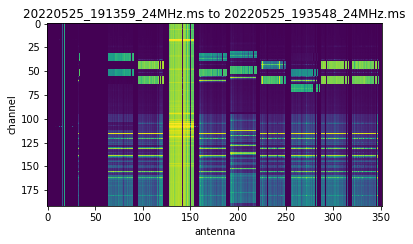

In [45]:
writergif = animation.PillowWriter(fps=1)
fig, ax = plt.subplots()

def f(fn):
    tb = read_mstar(fn)
    data = get_data(tb, show=False)
    return data

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for fn in filelist:
    ax.set_xlabel('antenna')
    ax.set_ylabel('channel')
    ax.set_title(f"{os.path.basename(filelist[0])} to {os.path.basename(filelist[-1])}")
    data = ax.imshow(f(fn), animated=True)
    ims.append([data])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=2000)

ani.save('tmp2.gif', writer=writergif)

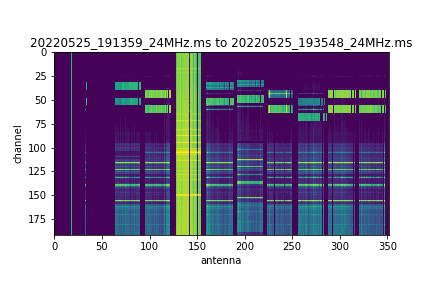

In [47]:
Image('tmp2.gif')